### 0. Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import TensorDataset
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.init as init
from tensorflow import keras 
import torch.nn.functional as F
from cnn.utils import generate_spiral_data, plot_spiral_data_decision_boundary, train_val_test_split, train_val, plot_train_val, test

### 1. Load Data

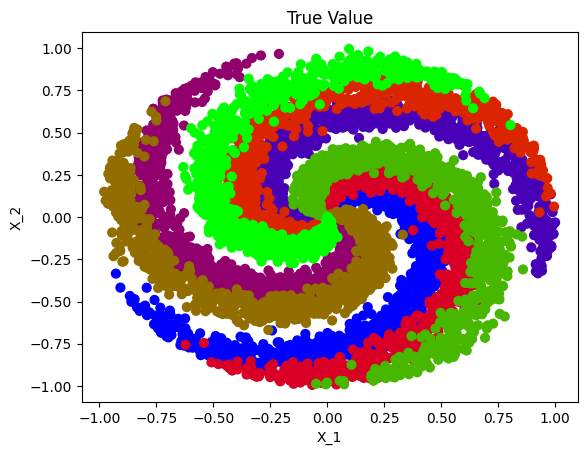

In [2]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 8 # number of classes
X, y = generate_spiral_data(N, D, K)

In [3]:
batch_size = 32 
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=.5, random_state=42)

def generate_dataloader(X, y, batch_size=32):
  X_tensor = torch.tensor(X, dtype=torch.float32)
  y_tensor = torch.tensor(y, dtype=torch.long)
  dataset = TensorDataset(X_tensor, y_tensor)
  dataloader = DataLoader(dataset, batch_size=batch_size)
  return dataloader


dataloader_train = generate_dataloader(X_train, y_train, batch_size)
dataloader_val = generate_dataloader(X_val, y_val, batch_size)
dataloader_test = generate_dataloader(X_test, y_test, batch_size)


### 2. Visualize Data

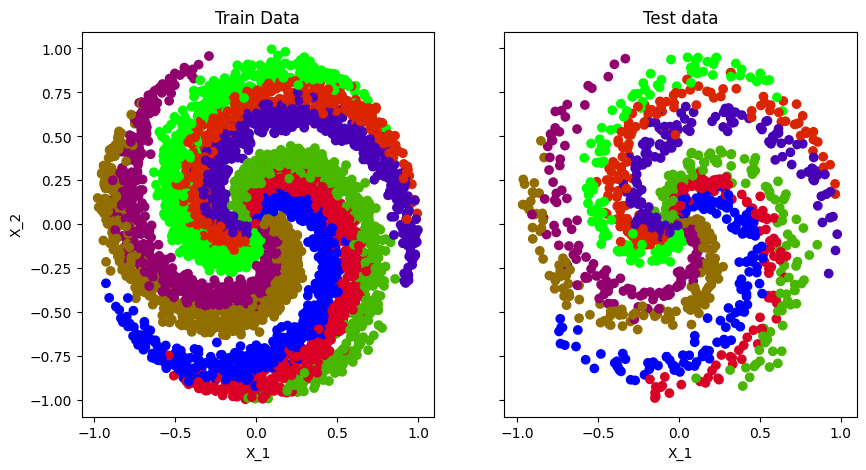

In [4]:
# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='brg')
train_ax.set_title("Train Data")
train_ax.set_xlabel("X_1")
train_ax.set_ylabel("X_2")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='brg')
test_ax.set_title("Test data")
test_ax.set_xlabel("X_1")
train_ax.set_ylabel("X_2")
plt.show()

### 3. Build Model

In [5]:
class Net(nn.Module):
  def __init__(self, input_size, num_classes, p=0.0):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, num_classes)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x), dim=1)
    return x
    

### 4. Train Model

In [6]:
EPOCHS = 1000
lr = 0.001 

model = Net(D, K)
#model = CNNWithDropout()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 

In [7]:
def plot_decision_boundary(model):
  x_1 = np.arange(-1, 1, 0.01)
  x_2 = np.arange(-1, 1, 0.01)
  X_1, X_2 = np.meshgrid(x_1, x_2)

  X_grid = np.c_[X_1.flatten(), X_2.flatten()]
  X_tensor = torch.tensor(X_grid, dtype=torch.float32)  

  model.eval()
  with torch.no_grad():
    output = model(X_tensor)

  _, pred = torch.max(output, dim=1)
  Z = pred.reshape(X_1.shape)

  plt.figure(figsize=(6, 5))
  plt.contourf(X_1, X_2, Z, cmap='brg')

  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.xlabel('X_1')
  plt.ylabel('X_2')
  plt.title('Model Predictions')
  plt.show()


In [9]:
train_losses = []
train_accuracies = []
for epoch in range(EPOCHS):
  running_loss = 0
  correct = 0
  total = 0
  for features, target in dataloader_train:
    model.train() 

    target = target.flatten()
    optimizer.zero_grad()
    output = model(features)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() 

    _, pred = torch.max(output, dim=1)
    correct += (pred == target).sum().item()
    total += target.size(0)
    
  if (epoch+1) % 10 == 0:
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:4f}, Accuracy: {epoch_accuracy:4f}")
  if epoch % 10 == 0:
    pass
    #plot_decision_boundary(model)


Epoch 10, Loss: 0.043628, Accuracy: 0.886786
Epoch 20, Loss: 0.043605, Accuracy: 0.885357
Epoch 30, Loss: 0.043564, Accuracy: 0.886250
Epoch 40, Loss: 0.043551, Accuracy: 0.887857
Epoch 50, Loss: 0.043543, Accuracy: 0.887500
Epoch 60, Loss: 0.043602, Accuracy: 0.884286
Epoch 70, Loss: 0.043458, Accuracy: 0.888036
Epoch 80, Loss: 0.043479, Accuracy: 0.887679
Epoch 90, Loss: 0.043459, Accuracy: 0.887857
Epoch 100, Loss: 0.043412, Accuracy: 0.889643
Epoch 110, Loss: 0.043395, Accuracy: 0.890179
Epoch 120, Loss: 0.043364, Accuracy: 0.890000
Epoch 130, Loss: 0.043308, Accuracy: 0.893036
Epoch 140, Loss: 0.043361, Accuracy: 0.888929
Epoch 150, Loss: 0.043278, Accuracy: 0.893929
Epoch 160, Loss: 0.043339, Accuracy: 0.891607
Epoch 170, Loss: 0.043295, Accuracy: 0.892321
Epoch 180, Loss: 0.043239, Accuracy: 0.895179
Epoch 190, Loss: 0.043295, Accuracy: 0.892143
Epoch 200, Loss: 0.043255, Accuracy: 0.893750
Epoch 210, Loss: 0.043245, Accuracy: 0.893393
Epoch 220, Loss: 0.043215, Accuracy: 0.8935

### 5. Test Model

Loss: 0.023101, Accuracy: 0.833333


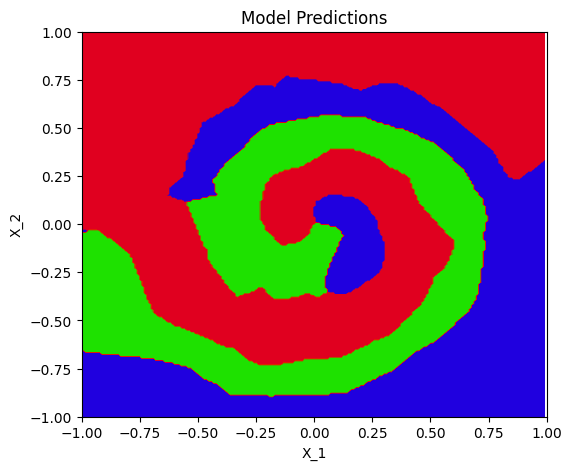

In [69]:
model.eval()

running_loss = 0
correct = 0
total = 0

with torch.no_grad():
  for features, target in dataloader_test:
    output = model(features)
    loss = criterion(output, target)
    running_loss += loss.item() 

    _, pred = torch.max(output, dim=1)
    correct += (pred == target).sum().item()
    total += target.size(0)
    
test_loss = running_loss / total
test_accuracy = correct / total
print(f"Loss: {test_loss:4f}, Accuracy: {test_accuracy:4f}")

plot_decision_boundary(model)